In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import pyreadr
import os

from data import pipeline

pd.set_option("display.precision", 2)

# Data preparation

In [2]:
# Load / Build dataset

X_train, Y_train, Y_train_prior, X_test, Y_test, Y_test_prior = pipeline.buildAndSave("SVR") # load / buildAndSave / build
print(X_train.shape, Y_train.shape)

Loading SVR dataset
Done!
(1050578, 31) (1050578, 1)


In [3]:
# Reduce dataset

from sklearn.model_selection import train_test_split

def reduceRandomly(X, Y, new_size):
    # Shuffle the dataset
    X_init, X_shuffled, Y_init, Y_shuffled = train_test_split(X, Y, test_size= len(X)-1)
    
    # Insert the non-shuffled value at a random index
    index = np.random.randint(0, len(X_shuffled))
    X_shuffled = np.concatenate((X_shuffled[:index], X_init, X_shuffled[index:]))
    Y_shuffled = np.concatenate((Y_shuffled[:index], Y_init, Y_shuffled[index:]))
    
    # Reduce the size of X and Y
    X_shuffled_reduced = X_shuffled[:new_size]
    Y_shuffled_reduced = Y_shuffled[:new_size]
    return X_shuffled_reduced, Y_shuffled_reduced

Y_train_original = Y_train
X_train, Y_train = reduceRandomly(X_train, Y_train, 37*300)

In [4]:
# Normalisation

from sklearn.preprocessing import StandardScaler

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train)
Y_train = Y_train.reshape(-1)
Y_train_original = sc_y.fit_transform(Y_train_original)
Y_train_original = Y_train_original.reshape(-1)


print(X_train.shape, Y_train.shape)

(11100, 31) (11100,)


# Training

In [5]:
# Import libraries for training and tuning

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

tune = False
overwrite = False
use_hyperparams = False
fit = False

In [6]:
# Define the model

if tune or (fit and not use_hyperparams):
    regressor = SVR(kernel= 'rbf',
                    C= 100,
                    verbose= 0)

### Tuning

In [7]:
# Define thet tuner

if tune:
    hp_C = {"C": stats.uniform(1, 1000)}

    tuner = RandomizedSearchCV(
        estimator= regressor,
        param_distributions= hp_C,
        n_iter= 20,
        cv= 5,
        random_state= 0,
        n_jobs= -1,
        verbose= 1)

In [8]:
# Reload tuner

if not overwrite and use_hyperparams:
    with open("svr_automl.pkl", "rb") as f:
        tuner = pickle.load(f)


# Search the best hyperparameters

if tune:
    tuner.fit(X_train, Y_train)
    
    
    # Get the results of the tuning

    tuner.cv_results_


# Save the hyperparameter

if tune and overwrite:
    with open("svr_automl.pkl", "wb") as f:
        pickle.dump(tuner, f)


if tune or use_hyperparams:
    best_hps = tuner.best_params_
    msg = f"""The best:
    - parameter of regulation found is {best_hps.get('C')}"""
    print(msg)

    with open('lstm_output.txt', 'w') as f:
        f.write(msg)

In [9]:
# Reload the hypermodel from the tuner

if use_hyperparams:
    with open("svr_automl.pkl", "rb") as f:
        tuner = pickle.load(f)
    regressor.set_params(**tuner.best_params_)

### Fitting

In [10]:
# Reload the model

if not fit:
    with open("svr_model.pkl", "rb") as f:
        regressor = pickle.load(f)


# Train the model

if fit:
    regressor.fit(X_train, Y_train)


# Save the model

if fit and overwrite:
    with open("svr_model.pkl", "wb") as f:
        pickle.dump(regressor, f)

In [11]:
# Visualise the loss

from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics

print('Loss (MSE) : %.3f' % statistics.mean([mean_squared_error(Y_train[decade-37:decade], regressor.predict(X_train[decade-37:decade])) for decade in range(37, len(Y_train), 37)]))

Loss (MSE) : 0.095


# Evaluation

In [12]:
# Reduce the size of the test dataset

X_test = X_test[:37*405]
Y_test = Y_test[:37*405]
print(X_test.shape, Y_test.shape)

(14985, 31) (14985, 1)


In [13]:
Y_test = list(Y_test_prior.reshape(-1)) + list(Y_test[:-3].reshape(-1))

In [14]:
# Compute error of naive model

Y_train_prior = Y_train_prior.reshape(-1)

Y_train = np.concatenate((Y_train_prior, Y_train_original[:-3]))
Y_train = Y_train.reshape(-1, 1)
Y_train = sc_y.inverse_transform(Y_train)

Y_train = Y_train.reshape(-1, 37)
year_growth_avg = [Y_train[:, decade].mean() for decade in range(37)]

Y_naive = []
while len(Y_naive) < len(Y_test):
        Y_naive += year_growth_avg

print('Test RMSE with naive model : %.3f' % statistics.mean([sqrt(mean_squared_error(Y_test[decade-37:decade], Y_naive[decade-37:decade])) for decade in range(37, len(Y_naive), 37)]))

Test RMSE with naive model : 20.626


In [15]:
# Compute error

Y_preds = regressor.predict(X_test)

print('Test RMSE with SVR: %.3f' % statistics.mean([sqrt(mean_squared_error(Y_test[decade-37:decade], Y_preds[decade-37:decade])) for decade in range(37, len(Y_preds), 37)]))

Test RMSE with SVR: 45.357


In [16]:
# Process results for plots

Y_preds = sc_y.inverse_transform(Y_preds.reshape(-1, 1))
Y_preds = list(Y_preds.reshape(-1))
Y_preds = [9.57]*3 + Y_preds

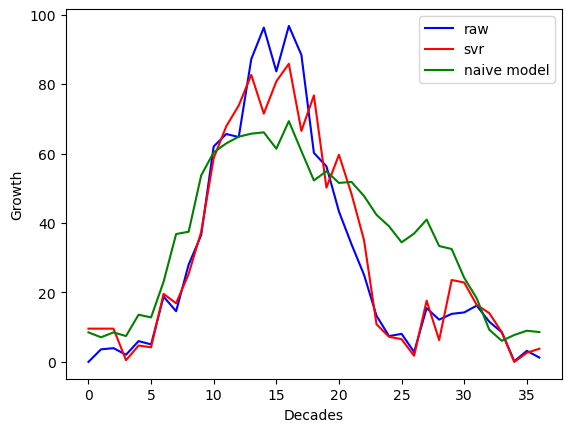

In [25]:
# Plot the results

year = 0
decades = [decade for decade in range(37)]
plt.plot(decades, Y_test[37*year:37*(year+1)], color="blue", label= "raw")
plt.plot(decades, Y_preds[37*year:37*(year+1)], color="red", label= "svr")
plt.plot(decades, Y_naive[37*year:37*(year+1)], color="green", label= "naive model")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()